In [1]:

import torch
import math
from data_loader import NEFG3x3Set
from VAE1 import AE
from AE import CustomLoss
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  

device = torch.device(dev) 
torch.cuda.set_device(0) 
# Download the MNIST Dataset
dataset = NEFG3x3Set("info_dat_charge.csv",
                     "data/3x12_16_damp00", "dat_charge", transform=True)

length = len(dataset)
train_split = math.floor(length*.7)
test_split = length - train_split

train_inds, test_inds = torch.utils.data.random_split(
    dataset, [train_split, test_split], generator=torch.Generator().manual_seed(42))


# Model Initialization
model = AE(1,[8, 16, 32, 64],32).to(dev)

# Validation using MSE Loss function
# loss_function = torch.nn.L1Loss()

# Using an Adam Optimizer with lr = 0.
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-4)

train_data = torch.utils.data.DataLoader(dataset=train_inds, batch_size=5,
                                         shuffle=True)
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=5,
                                        shuffle=True)


In [2]:
epochs = 20
outputs = []
losses = []
local_loss  = 0
txt1 = "Epoch {epoch} / "+str(epochs)
txt2 = "Average training loss: {loss}"
txt3 = "Average test loss: {loss}"


for epoch in range(epochs):
    if epoch%10==0:
        clear_output(wait=True)
    print(txt1.format(epoch = epoch))
    for (inp,_ , tar, _,_,_) in train_data:
        model.train()
        
        
        inp = inp.float()
        tar = tar.float()
        # Output of Autoencoder
       
        rec = model(tar)

        # Calculating the loss function
        loss = model.loss_function(rec[0],rec[1], rec[2], rec[3], M_N=5)

        local_loss=local_loss+loss['loss']
        optimizer.zero_grad()
        loss['loss'].backward()
        optimizer.step()
        
    
    print(txt2.format(loss = local_loss/len(train_data)))
    losses.append(local_loss/len(test_data))

    local_loss = 0
    kl_loss = 0
        
    for (inp, cmpr,tar, _,_,_) in test_data:
        model.eval()
        inp = inp.float()
        tar = tar.float()
        
        # Output of Autoencoder
        rec = model(tar)

        # Calculating the loss function
        loss = model.loss_function(rec[0],rec[1], rec[2], rec[3], M_N=5)
     

        local_loss=local_loss+loss['loss'].item()
        kl_loss+=loss['KLD'].item() 

    
    print(txt3.format(loss = local_loss/len(test_data)))
    print(kl_loss/len(test_data))
    
    local_loss = 0



Epoch 10 / 20
Average training loss: 0.014251361601054668
Average test loss: 0.022599335503592832
-0.002912196246060458
Epoch 11 / 20
Average training loss: 0.01380919013172388
Average test loss: 0.013748288849089524
-0.0010136545447550294
Epoch 12 / 20
Average training loss: 0.014486038126051426
Average test loss: 0.010358764684738486
-0.0004387298936833209
Epoch 13 / 20
Average training loss: 0.01669352501630783
Average test loss: 0.009436795631588347
-0.0002831045672050345
Epoch 14 / 20
Average training loss: 0.011978546157479286
Average test loss: 0.009477105456763646
-0.000279540261991679
Epoch 15 / 20
Average training loss: 0.01279151439666748
Average test loss: 0.027357463123098346
-0.003836452998152273
Epoch 16 / 20
Average training loss: 0.013885806314647198
Average test loss: 0.014753075384052072
-0.0010973772369279396
Epoch 17 / 20
Average training loss: 0.013532746583223343
Average test loss: 0.01265673519681947
-0.000924146891210036
Epoch 18 / 20
Average training loss: 0.0

In [3]:
torch.save(model.state_dict(), "trained_models/conv")

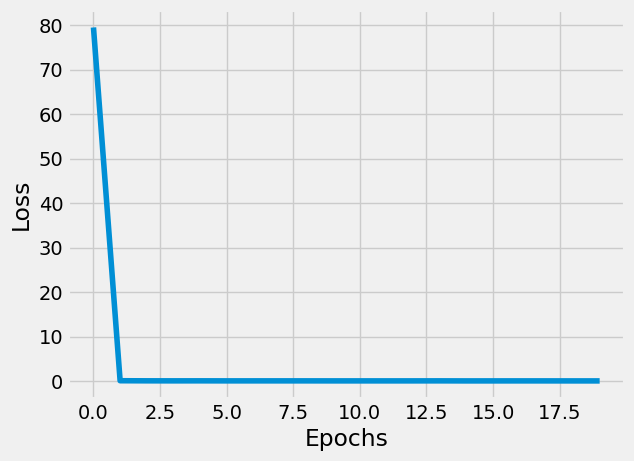

In [4]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Plotting the last 100 values
a = [i.cpu().detach().numpy() for i in losses[-30:]]

plt.plot(a)
plt.show()

In [5]:
Lf = torch.nn.L1Loss()

loss_og =0
loss_cmp=0
loss_inp=0
test_data = torch.utils.data.DataLoader(dataset=test_inds, batch_size=1,
                                        shuffle=True)
model.eval()

for (inp, cmpr,tar, _,_,_) in test_data:
    
    inp = inp.reshape(1,1,71,26).float()
    cmpr = cmpr.reshape(1,1,71,26).float()
    tar = tar.reshape(1, 1,71,26).float()
    # print(inp.shape)
    rec = model(tar)[0].float().reshape(1, 1, 71, 26)
    
    loss_inp += Lf(tar, inp).item()
    loss_cmp += Lf(tar, cmpr).item()
    loss_og += Lf(tar, rec).item()
    
print(loss_inp/len(dataset))
print(loss_og/len(dataset))
print(loss_cmp/len(dataset))


# Ref
# L1
# 0.0027429692533512697
# 0.0009202006362793332
# MSE
# 6.192370868955924e-05
# 1.0669039261460472e-05
# Linear for tar

# Smaller net - less gradient vanishing
# smaller batch size
# L1 0.002581117276478905

# Big net - more gradient vanishing
# smaller batch size
# L1 0.002215983445361106

# yes the size of the net matters - vanishing gradient
# This is the smallest size: 2 layers 8,64
# 0.0026394529265394645


# Try non linear
#  0.00245640212143684


0.0027429692533512697
0.02185131324458718
0.0009202006362793332
